In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os, re
import pandas as pd

### Notes

In this notebook I implemented a CycleGAN Network with real faces and faces from japanese paintings in the 16th and 17th century. 

I web-scraped the Kaokore images from a list of URL's, but I just had to convert the real faces from an existing dataset. Links to the notebooks where I created each of these TFrecords are linked below.

-- 

Feel free to train the CycleGAN from scratch, but I have also provided an option to use existing model weights below! Also dont forget to turn on TPU's! 

Thanks for coming across my notebook, hope you like it!


TFrecords Datasets:

- [Kaokore Faces TFrecords](https://www.kaggle.com/brendanartley/kaokore-faces)

- [Flickr-Faces-TFrecords- 512x512](https://www.kaggle.com/brendanartley/flickrfacestfrecords)

Original Datasets:

- [Arnaud58's Flickr Faces Data](https://www.kaggle.com/arnaud58/flickrfaceshq-dataset-ffhq)
- [Kaokore Dataset](https://github.com/rois-codh/kaokore)


### Detecting TPU

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


### Variables

In [3]:
KAOKORE_GCS_PATH = KaggleDatasets().get_gcs_path('kaokore-faces')
FLICKR_GCS_PATH = KaggleDatasets().get_gcs_path('flickrfacestfrecords')
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync


IMAGE_SIZE = [256,256]
OUTPUT_CHANNELS = 3

In [4]:
#this function counts number of images in all TFRecords
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)

KAOKORE_FILENAMES = tf.io.gfile.glob(str(KAOKORE_GCS_PATH + '/*.tfrec'))
FLICKR_FILENAMES = tf.io.gfile.glob(str(FLICKR_GCS_PATH + '/*.tfrec'))

NUM_KAOKORE_IMAGES = count_data_items(KAOKORE_FILENAMES)
NUM_FLICKR_IMAGES = count_data_items(FLICKR_FILENAMES)

print('KAOKORE Face Images: {}\nFlickr Face Images: {}'.format(NUM_KAOKORE_IMAGES, NUM_FLICKR_IMAGES))

KAOKORE Face Images: 8848
Flickr Face Images: 44201


### Simple Augmentation

Adding some simple rotatation and flips. 

### Loading Functions

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.image.resize(image, [*IMAGE_SIZE])
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) #asterix before removes list brackets
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    return dataset

### Visualizing Image Samples

Plotting examples of the TFrecords. Also good checkpoint to know that the input images are formatted correctly before training the model.

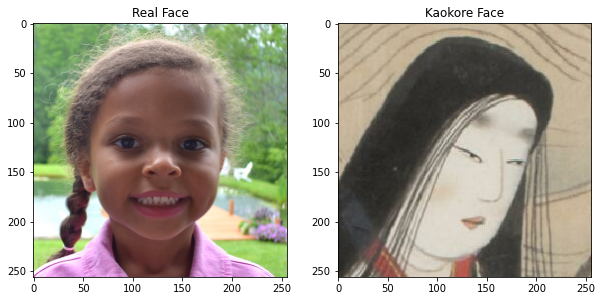

In [7]:
#re-run cell to get different variations of photo and kaokore paintings
kaokore_ds = load_dataset(KAOKORE_FILENAMES, labeled=True).batch(1)
flickr_ds = load_dataset(FLICKR_FILENAMES, labeled=True).batch(1)

example_kaokore = next(iter(kaokore_ds))
example_flickr = next(iter(flickr_ds))

plt.subplots(2,2,figsize=(10,10))

plt.subplot(121)
plt.title('Real Face')
plt.imshow(example_flickr[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Kaokore Face')
plt.imshow(example_kaokore[0] * 0.5 + 0.5)

### Building Generator

Downsample - Reduces the image dimensions by the stride length in the Conv2D layer.

Upsample - Increases the image dimensions by using the Conv2DTranspose layer which bascically does the reverse of the conv2d layer.

NOTE: Got the structure for upsample and downsample layers from Amy Jang.

- [Amy Jang's GAN Tutorial](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial)

In [8]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU()) #anything below zero is zero

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In the next cell we define out generator model.

The generator is downsampling our images and then upsampling whilst adding some long skip connections.

Skip connections are a strategy used to combat the vanishing gradient that often occurs in GAN's. They
basically skip some layers in the neural network and feed the output to layers further along the model. 

See here for skip connection info -> [link](https://theaisummer.com/skip-connections/#:~:text=At%20present%2C%20skip%20connection%20is,module%20in%20many%20convolutional%20architectures.&text=Skip%20connections%20in%20deep%20architectures,of%20only%20the%20next%20one)

In [9]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Building the discriminator

The discriminator outputs a small 2D image with high pixel values if it thinks the image is real, and outputs a small 2D image with low pixel values if it thinks that the image is made by the generator.

These outputs are what help us determine how effective the disriminators and generators truly are.

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

### Defining Genenerators and Discriminators

Defining model within strategy.scope to train cycleGAN on TPU's.

In [11]:
with strategy.scope():
    kaokore_generator = Generator() # transforms photos to kaokore-esque paintings
    photo_generator = Generator() # transforms kaokore paintings to be more like photos

    kaokore_discriminator = Discriminator() # differentiates real kaokore painting and generated kaokore painting
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

The generator is not trained yet and therefore isnt outputting anything remotely close to what we are looking for at the moment. 

The hope is that the generator learns to beat the disriminator by generating and image from the original photo that represents the face of a 16th century japanese face.

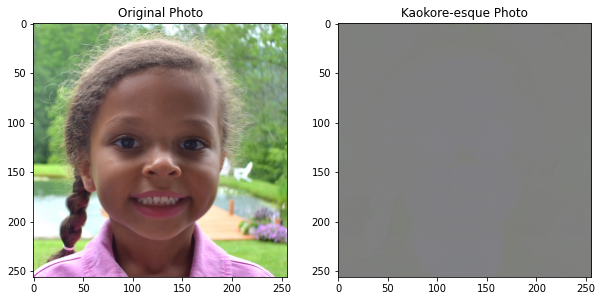

In [12]:
to_kaokore = kaokore_generator(example_flickr)

plt.subplots(2,2,figsize=(10,10))

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_flickr[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Kaokore-esque Photo")
plt.imshow(to_kaokore[0] * 0.5 + 0.5)
plt.show()

### Defining Model SubClass

In the next cell we are building a subclass of tf.keras.model.

During each training step the model is transforming a photo to a kaokore painting, and then transforming back into a photo. We therefore are training both the kaokore_generator and the photo_generator at the same time.

The difference between the input image and the resulting image is measured by the cycle-consistency loss which is a custom loss function defined later in this notebook.

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        kaokore_generator,
        photo_generator,
        kaokore_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.k_gen = kaokore_generator
        self.p_gen = photo_generator
        self.k_disc = kaokore_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        k_gen_optimizer,
        p_gen_optimizer,
        k_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.k_gen_optimizer = k_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.k_disc_optimizer = k_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_kaokore, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to kaokore back to photo
            fake_kaokore = self.k_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_kaokore, training=True)

            # kaokore to photo back to kaokore
            fake_photo = self.p_gen(real_kaokore, training=True)
            cycled_kaokore = self.k_gen(fake_photo, training=True)

            # generating itself
            same_kaokore = self.k_gen(real_kaokore, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_kaokore = self.k_disc(real_kaokore, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_kaokore = self.k_disc(fake_kaokore, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            kaokore_gen_loss = self.gen_loss_fn(disc_fake_kaokore)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_kaokore, cycled_kaokore, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_kaokore_gen_loss = kaokore_gen_loss + total_cycle_loss + self.identity_loss_fn(real_kaokore, same_kaokore, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            kaokore_disc_loss = self.disc_loss_fn(disc_real_kaokore, disc_fake_kaokore)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        kaokore_generator_gradients = tape.gradient(total_kaokore_gen_loss,
                                                  self.k_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        kaokore_discriminator_gradients = tape.gradient(kaokore_disc_loss,
                                                      self.k_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.k_gen_optimizer.apply_gradients(zip(kaokore_generator_gradients,
                                                 self.k_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.k_disc_optimizer.apply_gradients(zip(kaokore_discriminator_gradients,
                                                  self.k_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "kaokore_gen_loss": total_kaokore_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "kaokore_disc_loss": kaokore_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Defining Custom Loss Functions
The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. 

The perfect discriminator will output all 1s for real images and all 0s for fake images.

The discriminator loss output is the average of the real and generated loss.

In [14]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. 

Thus, it compares the generated image to a matrix of 1s to find the loss.

This constant battle between the discriminator and generator is why training a GAN is much harder than a single NN.

In [15]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In the cycleGAN two transformations occur ie.

Photo (input) -> Kaokore (generated) -> Photo (generated)

The following calc_cycle_loss is the difference between the real image, and the image that has gone through our model.

In [16]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The final loss function we have is the identity_loss which compares the input of the generator with the output of the generator. (ie difference between input photo + generated photo)

In [17]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### Compile + Train CycleGAN


We are using the Adam optimizer for both the discriminator and the generators here. 

More information in regards to each parameter for Adam can be found in TensorFlow docs here --> [link](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

In [18]:
with strategy.scope():
    kaokore_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    kaokore_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In the cell below we can define our generators and discriminators, and compile our model. All the tedious code has been completed above and the following is relatively simple.

Note if we wanted to alter the loss functions we would have to change the subclass code, and the respective loss functions above. 

Other TF-GAN Loss functions to try: --> [link](https://developers.google.com/machine-learning/gan/loss)

- Minimax Loss, Modified Minimax Los, Wasserstein Loss

In [19]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        kaokore_generator, photo_generator, kaokore_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        k_gen_optimizer = kaokore_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        k_disc_optimizer = kaokore_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

I included the steps_per_epoch as the NUM_KAOKORE_IMAGES/8 here or 1106.

Since we have such a large number of images in each dataset there will be considerable advantage in training the GAN for a longer time period. 

I started off training the model with the following fit parameters. (4hrs on TPU's)

- 100 epochs 
- 1106 steps_per_epoch.

In [20]:
# history = cycle_gan_model.fit(
#             tf.data.Dataset.zip((kaokore_ds, flickr_ds)),
#             epochs=100,
#             steps_per_epoch=NUM_KAOKORE_IMAGES/8,
#         )

In [21]:
# cycle_gan_model.save_weights('./CycleGAN_trained_TPU_model_weights.h5')

### Pre-Trained Weights

If you dont want to train the model from scratch, I have saved pretrained model weights to a datasets so that you can just visualize the work of the kaokore_generator.

In [22]:
#.built allows for the cutstom model weights to be loaded into the model
cycle_gan_model.built = True
cycle_gan_model.load_weights('../input/cyclegan-kaokore-model-weights/CycleGAN_trained_TPU_model_weights.h5')

### Visualize Generated KaoKore Faces

There are roughly 52,000 images that could randomly be selected here. Some of the generated images come out great and other may not look as good. 

Since this is a CycleGAN and we have two generator we can also do this the other way around. Simply replace the name of the generator and image_ds to do! 

Note: the photo_generator is much harder to train!

Also, feel free to re-run the following kernel as many times as you would like to get a different set of images!

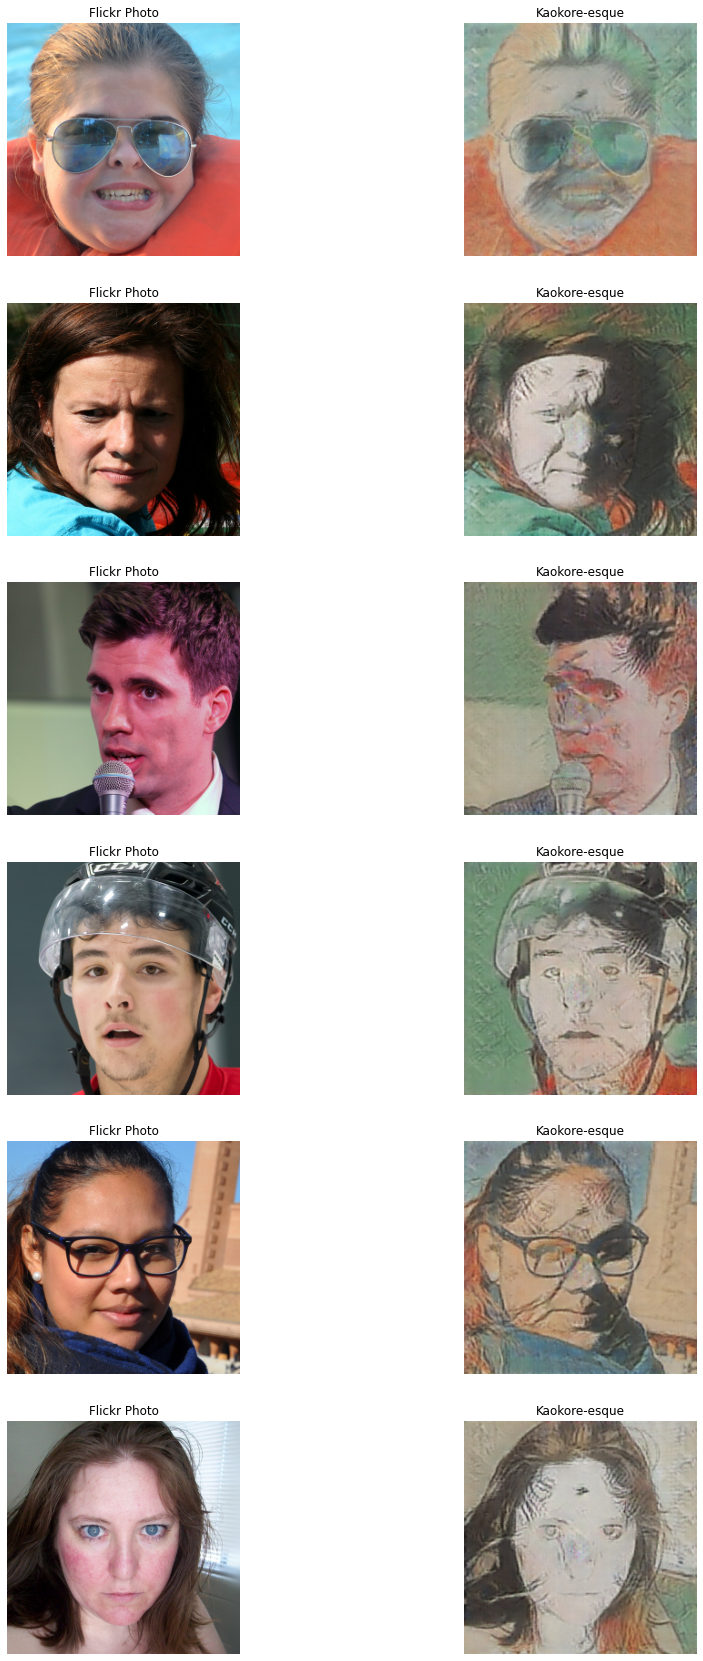

In [27]:
_, ax = plt.subplots(6, 2, figsize=(15, 30))
for i, img in enumerate(flickr_ds.take(6)):
    prediction = kaokore_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Flickr Photo")
    ax[i, 1].set_title("Kaokore-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")